In [50]:
%pip install -U -q langgraph langchain_google_genai google-generativeai

In [51]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from google.colab import userdata

In [68]:
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
model = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0)

In [62]:
class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    email_draft: Optional[str]
    messages: List[Dict[str, Any]]

In [63]:
def read_email(state: EmailState):
    email = state["email"]
    print(f"An AI Agent is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}


def classify_email(state: EmailState):
    email = state["email"]

    prompt = f"""
As a professional email reader, analyze this email and determine if it is spam or legitimate and should be brought to Mr. Prince attention.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only return the answer
Answer :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    response_text = response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text

    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response.content}
        ]
    else:
        new_messages = state.get("messages", [])

    return {
        "is_spam": is_spam,
        "messages": new_messages
    }


def handle_spam(state: EmailState):
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}


def drafting_response(state: EmailState):
    email = state["email"]

    prompt = f"""
As an AI Agent, draft a polite preliminary response to this email.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Draft a brief, professional response that Mr. Prince can review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]


    response = model.invoke(messages)


    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    return {
        "email_draft": response.content,
        "messages": new_messages
    }

def notify_mr_kaju(state: EmailState):
    email = state["email"]

    print("\n" + "=" * 50)
    print(f"Hello, I am your AI Agent. You have received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["email_draft"])
    print("=" * 50 + "\n")

    return {}


def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"


# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("drafting_response", drafting_response)
email_graph.add_node("notify_mr_kaju", notify_mr_kaju)

In [64]:


email_graph.add_edge(START, "read_email")

email_graph.add_edge("read_email", "classify_email")


email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "drafting_response"
    }
)

email_graph.add_edge("handle_spam", END)
email_graph.add_edge("drafting_response", "notify_mr_kaju")
email_graph.add_edge("notify_mr_kaju", END)


In [65]:
# Compile the graph
compiled_graph = email_graph.compile()

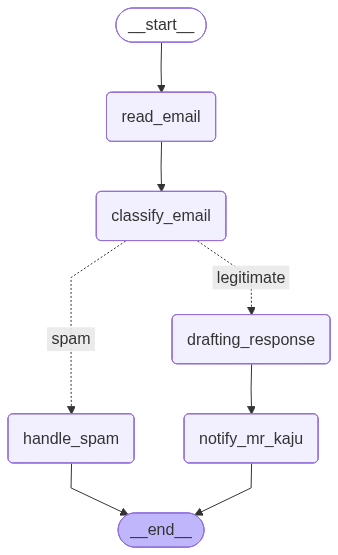

In [66]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [75]:
 # Example emails for testing
legitimate_email = {
    "sender": "Cognizant AI",
    "subject": "Potential partnership ! ",
    "body": "We would like to explore a potential partnership/collaboration with Vizuara. Do let us know a good time to reach you!"
}

spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    input={
        "email": legitimate_email,
        "is_spam": None,
        "spam_reason": None,
        "email_category": None,
        "email_draft": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "spam_reason": None,
        "email_category": None,
        "email_draft": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)


Processing legitimate email...
An AI Agent is processing an email from Cognizant AI with subject: Potential partnership ! 
ham

Hello, I am your AI Agent. You have received an email from Cognizant AI.
Subject: Potential partnership ! 

I've prepared a draft response for your review:
--------------------------------------------------
Of course. Here is a brief and professional draft response that Mr. Prince can review and personalize.

---

### **Draft Response for Mr. Prince's Review**

**Option 1: Standard Subject Line**
**Subject:** Re: Potential partnership !

**Option 2: More Formal Subject Line**
**Subject:** Re: Potential Partnership Inquiry - Vizuara & Cognizant AI

**Body:**

Dear Cognizant AI Team,

Thank you for reaching out and for your interest in exploring a potential partnership with Vizuara.

We are certainly open to discussing a collaboration. To make scheduling easier, you can view my availability and book a time directly via this link:

[Insert Mr. Prince's Schedulin

In [ ]:
!pip install langfuse[langchain]


In [ ]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-8c9e7d1c-ddb2-4287-a0ac-6725ef645db8"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-5fcf7626-23c0-4dab-a3e2-d4cda1017781"
#os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"  # 🇪🇺 EU region
os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region

In [76]:
from langfuse.langchain import CallbackHandler
langfuse_handler = CallbackHandler()

In [77]:

print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    input={
        "email": legitimate_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)


print("\nProcessing spam email...")
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)


Processing legitimate email...
An AI Agent is processing an email from Cognizant AI with subject: Potential partnership ! 
ham

Hello, I am your AI Agent. You have received an email from Cognizant AI.
Subject: Potential partnership ! 

I've prepared a draft response for your review:
--------------------------------------------------
Of course. Here is a brief and professional draft response that Mr. Prince can review and personalize.

---

### **Draft Response for Mr. Prince's Review**

**Option 1: Standard Subject Line**
**Subject:** Re: Potential partnership !

**Option 2: More Formal Subject Line**
**Subject:** Re: Potential Partnership Inquiry - Vizuara & Cognizant AI

**Body:**

Dear Cognizant AI Team,

Thank you for reaching out and for your interest in exploring a potential partnership with Vizuara.

We are certainly open to discussing a collaboration. To make scheduling easier, you can view my availability and book a time directly via this link:

[Insert Mr. Prince's Schedulin